In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from multiprocessing import Process, Pipe
import argparse
import gym

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 建立Actor和Critic网络

In [2]:
class ActorCritic(nn.Module):
    ''' A2C网络模型，包含一个Actor和Critic
    '''
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [3]:
class A2C:
    ''' A2C算法
    '''
    def __init__(self,n_states,n_actions,cfg) -> None:
        self.gamma = cfg.gamma
        self.device = cfg.device
        self.model = ActorCritic(n_states, n_actions, cfg.hidden_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters())

    def compute_returns(self,next_value, rewards, masks):
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * masks[step]
            returns.insert(0, R)
        return returns

In [4]:
def make_envs(env_name):
    def _thunk():
        env = gym.make(env_name)
        env.seed(2)
        return env
    return _thunk
def test_env(env,model,vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(cfg.device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


def train(cfg,envs):
    print('Start training!')
    print(f'Env:{cfg.env_name}, Algorithm:{cfg.algo_name}, Device:{cfg.device}')
    env = gym.make(cfg.env_name) # a single env
    env.seed(10)
    n_states  = envs.observation_space.shape[0]
    n_actions = envs.action_space.n
    model = ActorCritic(n_states, n_actions, cfg.hidden_dim).to(cfg.device)
    optimizer = optim.Adam(model.parameters())
    step_idx    = 0
    test_rewards = []
    test_ma_rewards = []
    state = envs.reset()
    while step_idx < cfg.max_steps:
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0
        # rollout trajectory
        for _ in range(cfg.n_steps):
            state = torch.FloatTensor(state).to(cfg.device)
            dist, value = model(state)
            action = dist.sample()
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(cfg.device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(cfg.device))
            state = next_state
            step_idx += 1
            if step_idx % 200 == 0:
                test_reward = np.mean([test_env(env,model,True) for _ in range(10)])
                print(f"step_idx:{step_idx}, test_reward:{test_reward}")
                test_rewards.append(test_reward)
                if test_ma_rewards:
                    test_ma_rewards.append(0.9*test_ma_rewards[-1]+0.1*test_reward)
                else:
                    test_ma_rewards.append(test_reward) 
                # plot(step_idx, test_rewards)   
        next_state = torch.FloatTensor(next_state).to(cfg.device)
        _, next_value = model(next_state)
        returns = compute_returns(next_value, rewards, masks)
        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()
        values    = torch.cat(values)
        advantage = returns - values
        actor_loss  = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Finish training！')
    return test_rewards, test_ma_rewards

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 
def plot_rewards(rewards, ma_rewards, cfg, tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title("learning curve on {} of {} for {}".format(
        cfg.device, cfg.algo_name, cfg.env_name))
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(ma_rewards, label='ma rewards')
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/opt/anaconda3/lib/python3.12/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.res

Start training!
Env:CartPole-v0, Algorithm:A2C, Device:cpu


/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.boo

step_idx:200, test_reward:11.2
step_idx:400, test_reward:11.5
step_idx:600, test_reward:11.5
step_idx:800, test_reward:10.8
step_idx:1000, test_reward:12.8
step_idx:1200, test_reward:13.3
step_idx:1400, test_reward:13.4
step_idx:1600, test_reward:26.0
step_idx:1800, test_reward:62.3
step_idx:2000, test_reward:63.7
step_idx:2200, test_reward:55.5
step_idx:2400, test_reward:58.6
step_idx:2600, test_reward:73.0
step_idx:2800, test_reward:96.6
step_idx:3000, test_reward:136.4
step_idx:3200, test_reward:92.5
step_idx:3400, test_reward:130.1
step_idx:3600, test_reward:119.0
step_idx:3800, test_reward:154.7
step_idx:4000, test_reward:100.5
step_idx:4200, test_reward:84.0
step_idx:4400, test_reward:168.0
step_idx:4600, test_reward:155.0
step_idx:4800, test_reward:193.0
step_idx:5000, test_reward:62.5
step_idx:5200, test_reward:181.0
step_idx:5400, test_reward:186.4
step_idx:5600, test_reward:155.3
step_idx:5800, test_reward:181.8
step_idx:6000, test_reward:193.0
step_idx:6200, test_reward:172.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


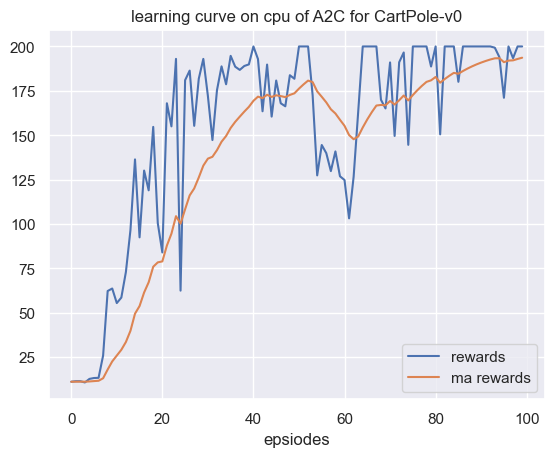

In [6]:
import easydict
from common.multiprocessing_env import SubprocVecEnv
cfg = easydict.EasyDict({
        "algo_name": 'A2C',
        "env_name": 'CartPole-v0',
        "n_envs": 8,
        "max_steps": 20000,
        "n_steps":5,
        "gamma":0.99,
        "lr": 1e-3,
        "hidden_dim": 256,
        "device":torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
})
envs = [make_envs(cfg.env_name) for i in range(cfg.n_envs)]
envs = SubprocVecEnv(envs) 
rewards,ma_rewards = train(cfg,envs)
plot_rewards(rewards, ma_rewards, cfg, tag="train") # 画出结果